In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from setproctitle import setproctitle
setproctitle("ENRICO")

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-08-22 17:30:46.961045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 17:30:47.776480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-22 17:30:49.289413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 17:30:49.349357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
from tqdm import trange
from UltimateTicTacToeEnvSelfPlay import UltimateTicTacToeEnvSelfPlay
from DQNAgent import DQNAgent
from A2CAgent import A2CAgent
from DoubleDQNAgent import DoubleDQNAgent
from PPOAgent import PPOAgent

# DQN

In [6]:
def asses_performance_dqn(agent):
    NUM_OF_GAMES = 1000
    performance_envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(NUM_OF_GAMES)]
    dones = np.zeros((NUM_OF_GAMES,), dtype=bool)
    final_rewards = np.zeros((NUM_OF_GAMES,))
    while(not np.all(dones) != 0):
        performance_states = np.array([env.to_state()[0] for env in performance_envs])
        performance_available_actions = np.array([env.to_state()[1] for env in performance_envs])
        performance_actions = agent.choose_action(performance_states, performance_available_actions, True)
        performance_r1 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
          if dones[i] == True:
            continue
          _, performance_r1[i], game_finished[i], _  = performance_envs[i].step(performance_actions[i])
          if game_finished[i] == True:
              dones[i] = True
              final_rewards[i] = performance_r1[i]

        states_opponent = np.array([env.to_state()[0] for env in performance_envs])
        available_actions_opponent = np.array([env.to_state()[1] for env in performance_envs])
        actions_opponent = np.full(available_actions_opponent.shape[0], -1, dtype=int)
        one_indices = available_actions_opponent == 1
        # For each row where there is at least one '1', select a random index of '1'
        for i in range(available_actions_opponent.shape[0]):
            valid_indices = np.where(one_indices[i])[0]
            if valid_indices.size > 0:
                actions_opponent[i] = np.random.choice(valid_indices)
        performance_r2 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
              if dones[i] == True:
                continue
              _, performance_r2[i], game_finished[i], _  = performance_envs[i].step(actions_opponent[i])
              if game_finished[i] == True:
                  dones[i] = True
                  final_rewards[i] = -performance_r2[i]

    return np.count_nonzero(final_rewards == 1)/len(dones), np.count_nonzero(final_rewards == 0)/len(dones)

In [7]:
# Initialize the Agent
GAMES = 128
ITERATIONS = 20000
DQN_rewards = []
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81
agent = DQNAgent(action_space_size, state_space_shape, exploration_rate=1.0, learning_rate=0.0001)

performance_dqn = []
draws_dqn = []
performance_with_draws_dqn = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.choose_action(states, available_actions)
r1 = np.zeros(GAMES)
exploration_rate_history = np.zeros(ITERATIONS)
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

# Training Loop
for episode in trange(ITERATIONS):

    if episode % 1000 == 0:
        win, draw = asses_performance_dqn(agent)
        performance_dqn.append(win)
        draws_dqn.append(draw)
        performance_with_draws_dqn.append(win+draw)

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.choose_action(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    DQN_rewards.append(np.average(rewards))
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.update_q_values(states, actions, rewards, next_states, dones, next_states_available_actions)

    if(not agent.exploration_rate <= 0.05):
        new_er = 0.05 + (1.0 - 0.05) * np.exp(-0.001 * episode)
        agent.set_exploration_rate(new_er)
    exploration_rate_history[episode] = agent.exploration_rate

    states = states_opponent
    available_actions = available_actions_opponent
    actions = actions_opponent
    r1 = r2

2024-08-19 17:12:11.042997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-19 17:12:11.043281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-19 17:12:11.043504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

KeyboardInterrupt: 

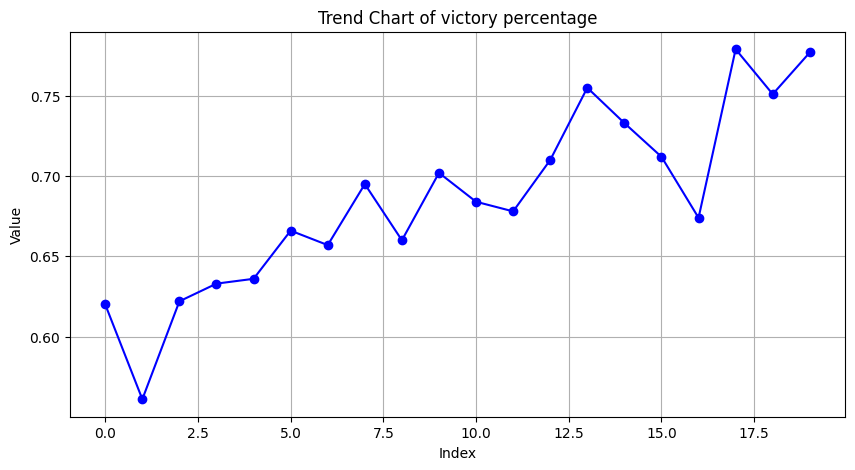

: 

In [ ]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(performance_with_draws_dqn, marker='o', linestyle='-', color='b')
# plt.plot(performance_dqn, marker='o', linestyle='-', color='g')
# plt.plot(draws, marker='o', linestyle='-', color='r')
plt.title('Trend Chart of victory percentage')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

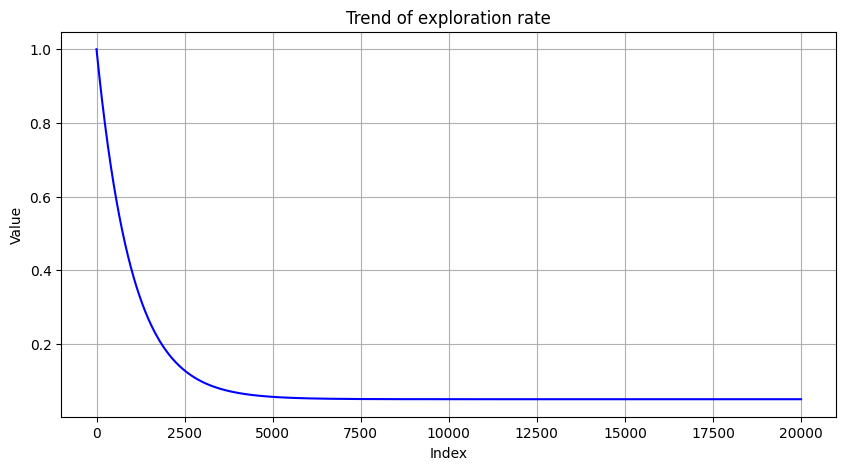

In [ ]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(exploration_rate_history, linestyle='-', color='b')
plt.title('Trend of exploration rate')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Double DQN

In [9]:
# Initialize the Agent
GAMES = 256
ITERATIONS = 5000
DQN_rewards = []
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81
agent = DoubleDQNAgent(action_space_size, state_space_shape, exploration_rate=1.0)

performance_double_dqn = []
draws_double_dqn = []
performance_with_draws_double_dqn = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.choose_action(states, available_actions)
r1 = np.zeros(GAMES)
exploration_rate_history = np.zeros(ITERATIONS)
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

# Training Loop
for episode in trange(ITERATIONS):

    if episode % 100 == 0:
        win, draw = asses_performance_dqn(agent)
        performance_double_dqn.append(win)
        draws_double_dqn.append(draw)
        performance_with_draws_double_dqn.append(win+draw)

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.choose_action(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    DQN_rewards.append(np.average(rewards))
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.update_q_values(states, actions, rewards, next_states, dones, next_states_available_actions, episode)

    if(not agent.exploration_rate <= 0.05):
        agent.set_exploration_rate(agent.exploration_rate - 0.95/(ITERATIONS*0.8))
    exploration_rate_history[episode] = agent.exploration_rate

    states = states_opponent
    actions = actions_opponent
    r1 = r2

100%|██████████| 5000/5000 [18:14<00:00,  4.57it/s]  


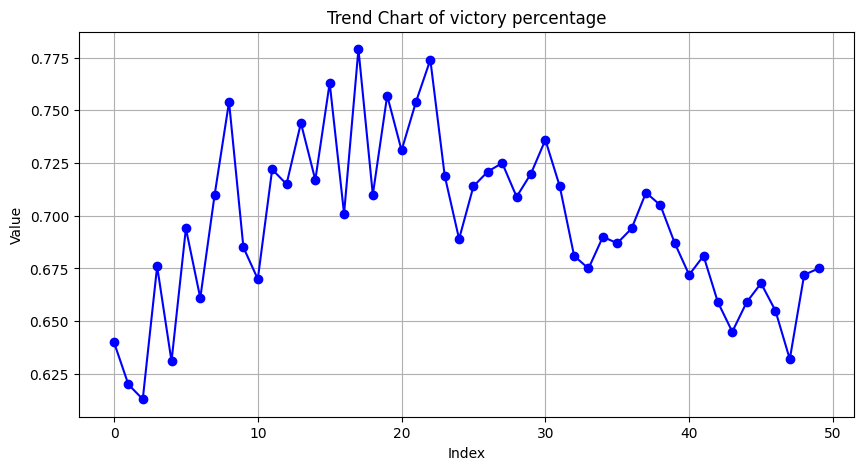

In [10]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(performance_with_draws_double_dqn, marker='o', linestyle='-', color='b')
# plt.plot(performance_double_dqn, marker='o', linestyle='-', color='g')
# plt.plot(draws_double_dqn, marker='o', linestyle='-', color='r')
plt.title('Trend Chart of victory percentage')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# A2C

In [7]:
def asses_performance_a2c(agent):
    NUM_OF_GAMES = 1000
    performance_envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(NUM_OF_GAMES)]
    dones = np.zeros((NUM_OF_GAMES,), dtype=bool)
    final_rewards = np.zeros((NUM_OF_GAMES,))
    while(not np.all(dones) != 0):
        performance_states = np.array([env.to_state()[0] for env in performance_envs])
        performance_available_actions = np.array([env.to_state()[1] for env in performance_envs])
        performance_actions = agent.act(performance_states, performance_available_actions)
        performance_r1 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
          if dones[i] == True:
            continue
          _, performance_r1[i], game_finished[i], _  = performance_envs[i].step(performance_actions[i])
          if game_finished[i] == True:
              dones[i] = True
              final_rewards[i] = performance_r1[i]

        states_opponent = np.array([env.to_state()[0] for env in performance_envs])
        available_actions_opponent = np.array([env.to_state()[1] for env in performance_envs])
        actions_opponent = np.full(available_actions_opponent.shape[0], -1, dtype=int)
        one_indices = available_actions_opponent == 1
        # For each row where there is at least one '1', select a random index of '1'
        for i in range(available_actions_opponent.shape[0]):
            valid_indices = np.where(one_indices[i])[0]
            if valid_indices.size > 0:
                actions_opponent[i] = np.random.choice(valid_indices)
        performance_r2 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
              if dones[i] == True:
                continue
              _, performance_r2[i], game_finished[i], _  = performance_envs[i].step(actions_opponent[i])
              if game_finished[i] == True:
                  dones[i] = True
                  final_rewards[i] = -performance_r2[i]

    return np.count_nonzero(final_rewards == 1)/len(dones), np.count_nonzero(final_rewards == 0)/len(dones)

In [8]:
# Initialize the Agent
GAMES = 128
ITERATIONS = 10000
DQN_rewards = []
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81

agent = A2CAgent(state_space_shape, action_space_size)

performance_a2c = []
draws_a2c = []
performance_with_draws_a2c = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.act(states, available_actions)
r1 = np.zeros(GAMES)
exploration_rate_history = np.zeros(ITERATIONS)
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

# Training Loop
for episode in trange(ITERATIONS):

    if episode % 1000 == 0:
        win, draw = asses_performance_a2c(agent)
        performance_a2c.append(win)
        draws_a2c.append(draw)
        performance_with_draws_a2c.append(win+draw)

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.act(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    DQN_rewards.append(np.average(rewards))
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.train(states, actions, rewards, next_states, dones, available_actions)

    states = states_opponent
    actions = actions_opponent
    available_actions = available_actions_opponent
    r1 = r2

2024-08-22 10:01:03.761553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 10:01:03.761869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 10:01:03.762110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

  9%|▉         | 946/10000 [01:09<11:06, 13.59it/s] 


KeyboardInterrupt: 

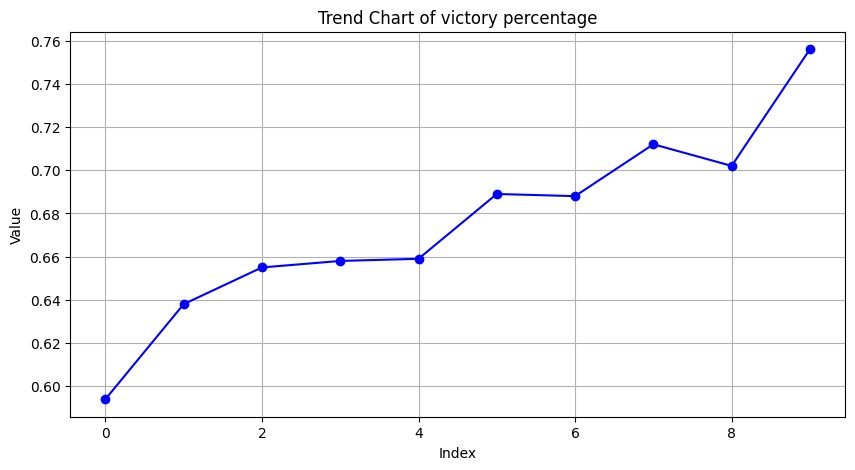

In [27]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(performance_with_draws_a2c, marker='o', linestyle='-', color='b')
# plt.plot(performance_a2c, marker='o', linestyle='-', color='g')
# plt.plot(draws, marker='o', linestyle='-', color='r')
plt.title('Trend Chart of victory percentage')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# PPO

In [9]:
# Initialize the Agent
GAMES = 128
ITERATIONS = 10000
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81

agent = PPOAgent(state_space_shape, action_space_size)

performance_ppo = []
draws_ppo = []
performance_with_draws_ppo = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.act(states, available_actions)
r1 = np.zeros(GAMES)
exploration_rate_history = np.zeros(ITERATIONS)
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

# Training Loop
for episode in trange(ITERATIONS):

    if episode % 1000 == 0:
        win, draw = asses_performance_a2c(agent)
        performance_ppo.append(win)
        draws_ppo.append(draw)
        performance_with_draws_ppo.append(win+draw)

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.act(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.train(states, actions, rewards, next_states, dones, available_actions)

    states = states_opponent
    actions = actions_opponent
    available_actions = available_actions_opponent
    r1 = r2

100%|██████████| 10000/10000 [22:53<00:00,  7.28it/s] 


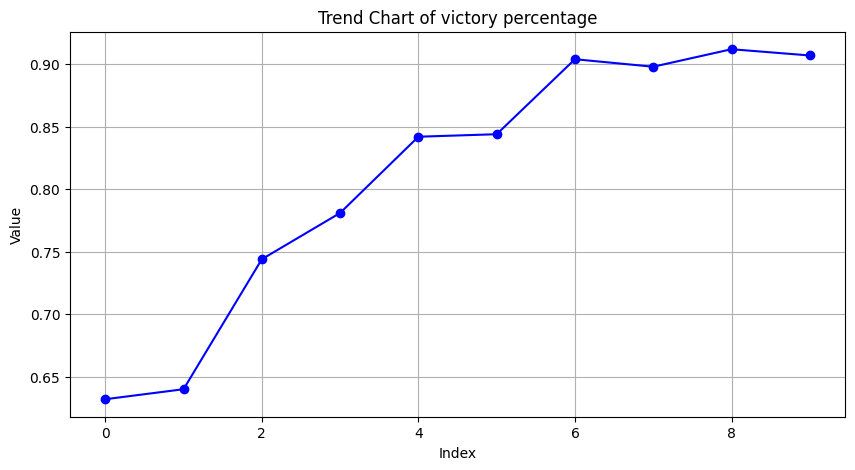

: 

In [10]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(performance_with_draws_ppo, marker='o', linestyle='-', color='b')
# plt.plot(performance_a2c, marker='o', linestyle='-', color='g')
# plt.plot(draws, marker='o', linestyle='-', color='r')
plt.title('Trend Chart of victory percentage')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()